In [15]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 195.46it/s]


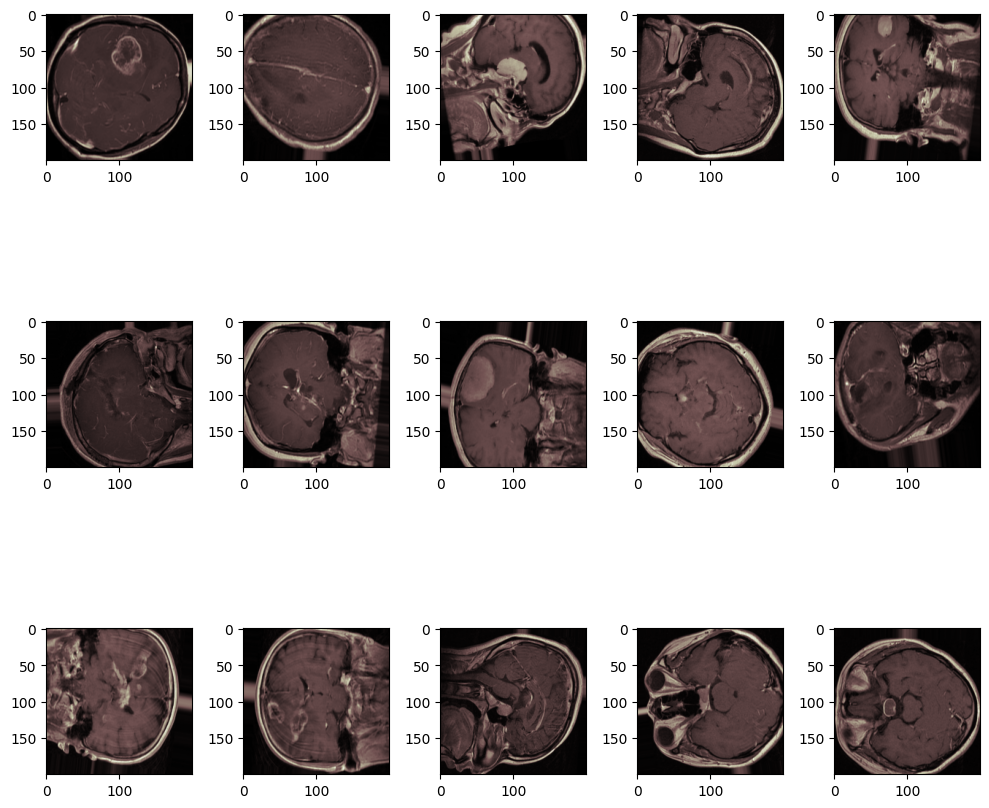

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-07 16:26:52.952744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:26:53.298934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 99, 99, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-07 16:27:04.012829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-07 16:27:04.600553: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-07 16:27:04.600576: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-07 16:27:04.600686: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-07 16:27:05.243108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7625
Epoch 1: saving model to model-Xception.h5
Epoch 1: 40.49 seconds
264/264 [==============================] - 40s 133ms/step - loss: 0.5621 - accuracy: 0.7625 - val_loss: 1.1472 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9005
Epoch 2: saving model to model-Xception.h5
Epoch 2: 34.22 seconds
264/264 [==============================] - 34s 130ms/step - loss: 0.2538 - accuracy: 0.9005 - val_loss: 2.1125 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9574
Epoch 3: saving model to model-Xception.h5
Epoch 3: 33.48 seconds
264/264 [==============================] - 33s 127ms/step - loss: 0.1162 - accuracy: 0.9574 - val_loss: 1.1099 - val_accuracy: 0.5247 - lr: 1.0000e-04
Epoch 4/50
264/264 [==============================] - ETA: 0s - loss: 0.

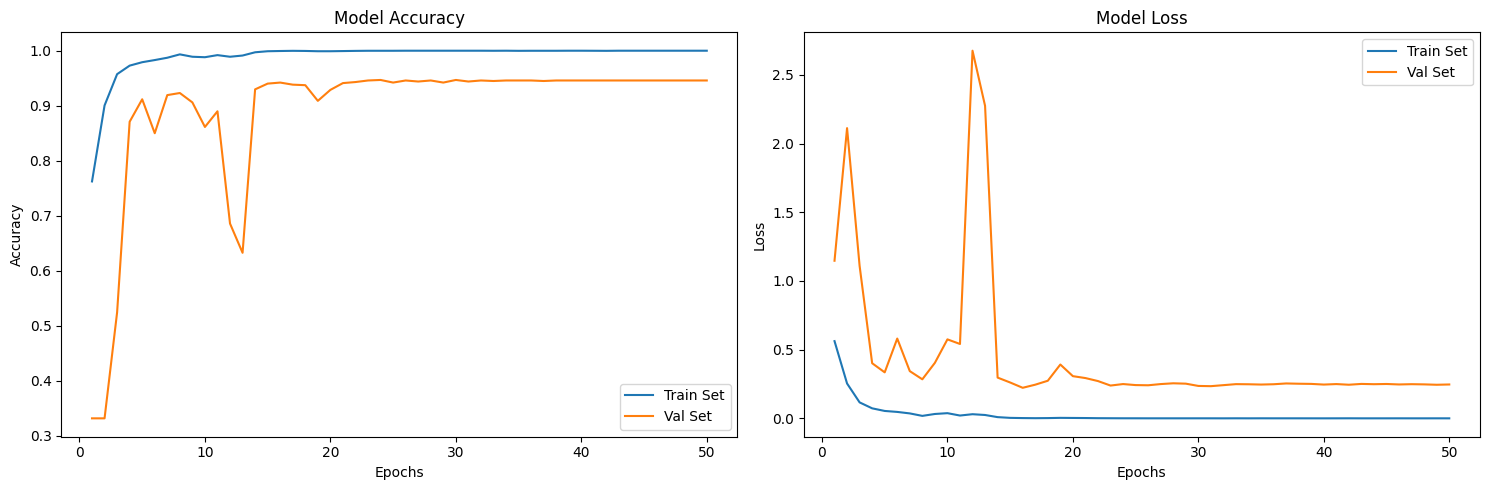

In [5]:
draw_curve(history)

20/20 [==============================] - 0s 17ms/step - loss: 0.2368 - accuracy: 0.9511
Test Accuracy:  95.11
              precision    recall  f1-score   support

      glioma     0.9683    0.9615    0.9649       286
  meningioma     0.9197    0.8873    0.9032       142
   pituitary     0.9482    0.9839    0.9657       186

    accuracy                         0.9511       614
   macro avg     0.9454    0.9442    0.9446       614
weighted avg     0.9510    0.9511    0.9509       614



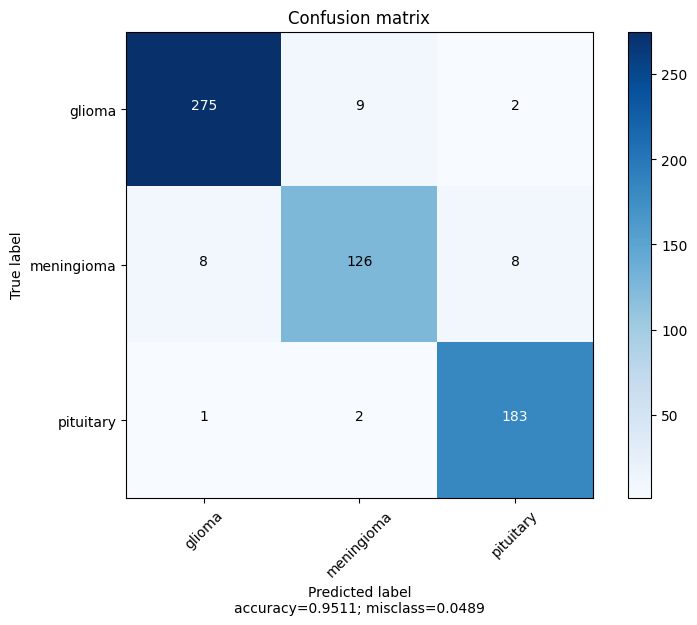

In [6]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [7]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 195.30it/s]


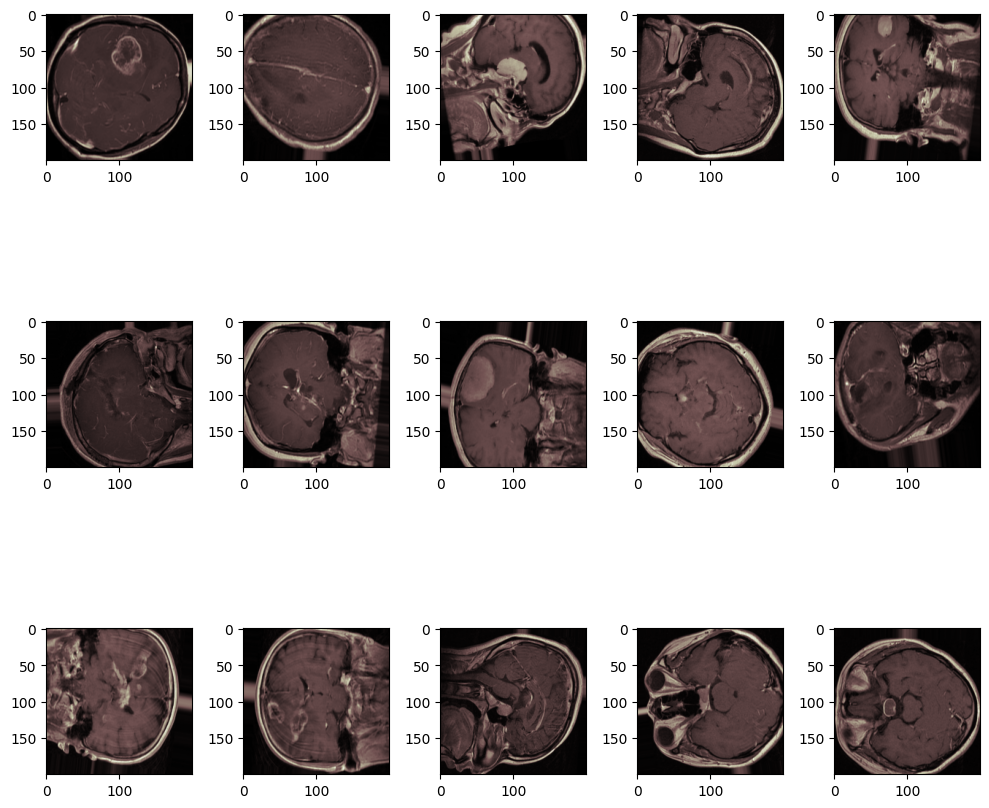

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7638
Epoch 1: saving model to model-Xception.h5
Epoch 1: 38.30 seconds
264/264 [==============================] - 38s 133ms/step - loss: 0.5655 - accuracy: 0.7638 - val_loss: 1.1432 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9049
Epoch 2: saving model to model-Xception.h5
Epoch 2: 34.06 seconds
264/264 [==============================] - 34s 129ms/step - loss: 0.2508 - accuracy: 0.9049 - val_loss: 2.0184 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9564
Epoch 3: saving model to model-Xception.h5
Epoch 3: 33.70 seconds
264/264 [==============================] - 34s 128ms/step - loss: 0.1189 - accuracy: 0.9564 - val_loss: 1.1338 - val_accuracy: 0.6091 - lr: 1.0000e-04
E

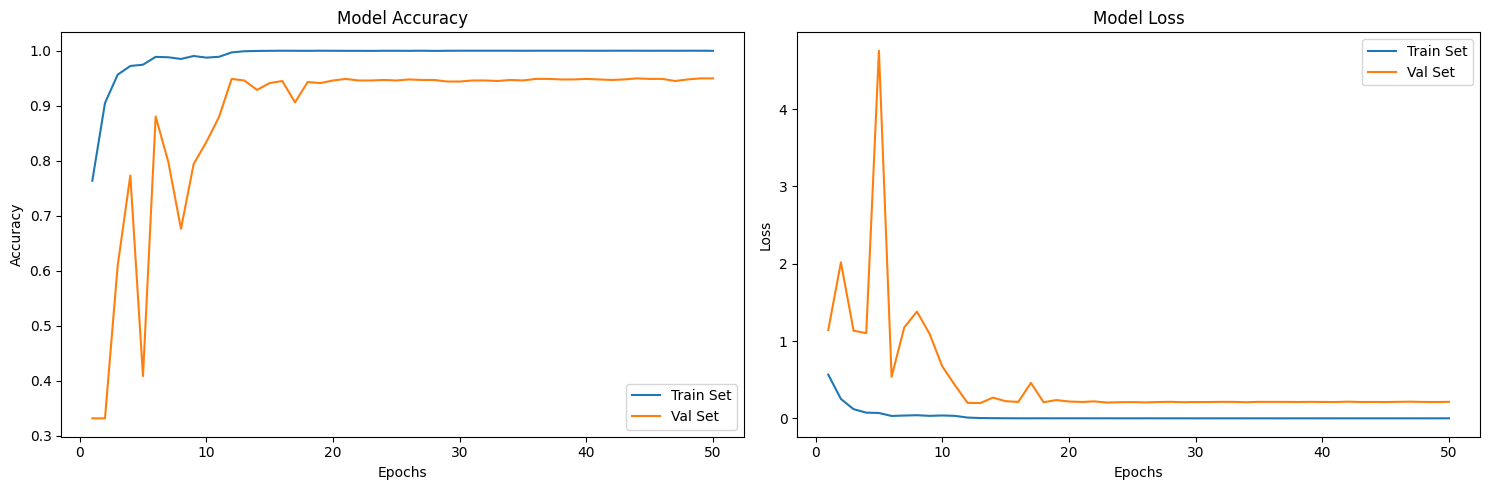

20/20 [==============================] - 0s 18ms/step - loss: 0.2238 - accuracy: 0.9528
Test Accuracy:  95.28
              precision    recall  f1-score   support

      glioma     0.9682    0.9580    0.9631       286
  meningioma     0.9041    0.9296    0.9167       142
   pituitary     0.9676    0.9624    0.9650       186

    accuracy                         0.9528       614
   macro avg     0.9466    0.9500    0.9482       614
weighted avg     0.9532    0.9528    0.9529       614



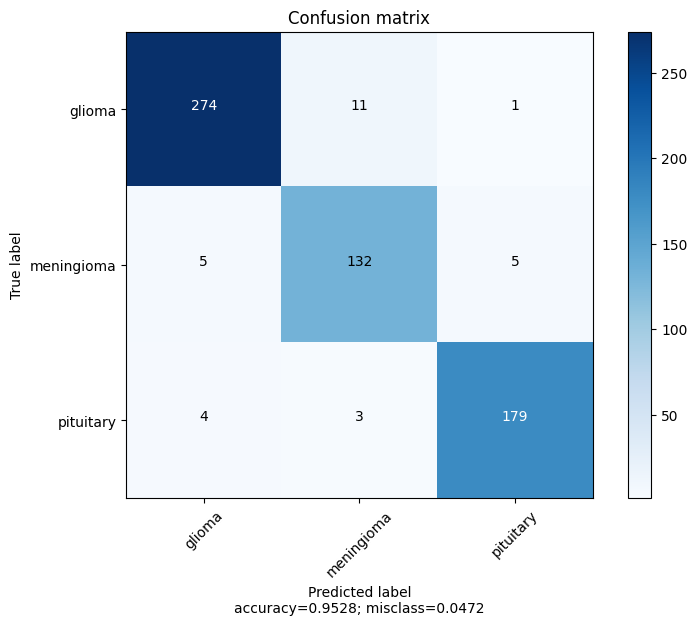

In [9]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f


100%|██████████| 186/186 [00:00<00:00, 194.44it/s]


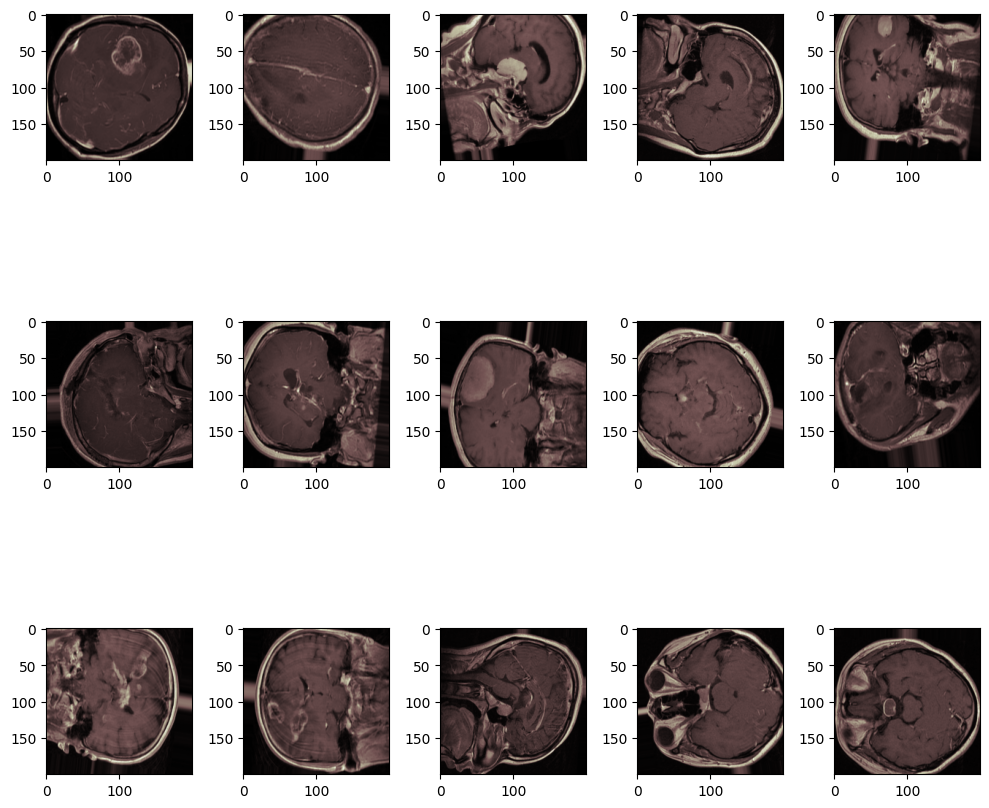

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7638
Epoch 1: saving model to model-Xception.h5
Epoch 1: 36.46 seconds
264/264 [==============================] - 36s 128ms/step - loss: 0.5650 - accuracy: 0.7638 - val_loss: 1.1300 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9080
Epoch 2: saving model to model-Xception.h5
Epoch 2: 33.37 seconds
264/264 [==============================] - 33s 126ms/step - loss: 0.2473 - accuracy: 0.9080 - val_loss: 2.3596 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9569
Epoch 3: saving model to model-Xception.h5
Epoch 3: 33.32 seconds
264/264 [==============================] - 33s 126ms/step - loss: 0.1245 - accuracy: 0.9569 - val_loss: 0.7750 - val_accuracy: 0.6812 - lr: 1.0000e-04
E

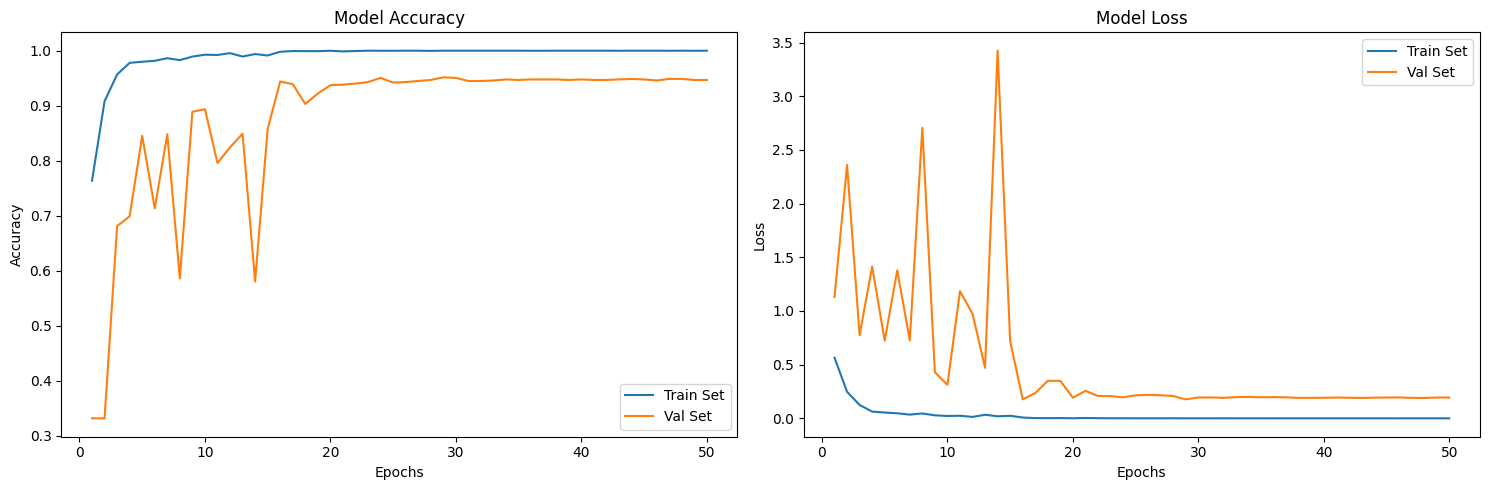

20/20 [==============================] - 0s 18ms/step - loss: 0.2628 - accuracy: 0.9463
Test Accuracy:  94.63
              precision    recall  f1-score   support

      glioma     0.9644    0.9476    0.9559       286
  meningioma     0.9130    0.8873    0.9000       142
   pituitary     0.9436    0.9892    0.9659       186

    accuracy                         0.9463       614
   macro avg     0.9403    0.9414    0.9406       614
weighted avg     0.9462    0.9463    0.9460       614



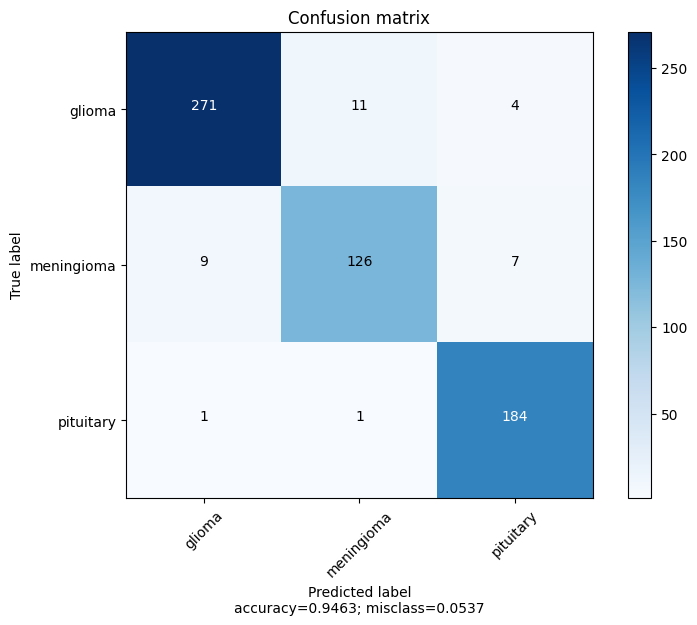

In [12]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.44it/s]


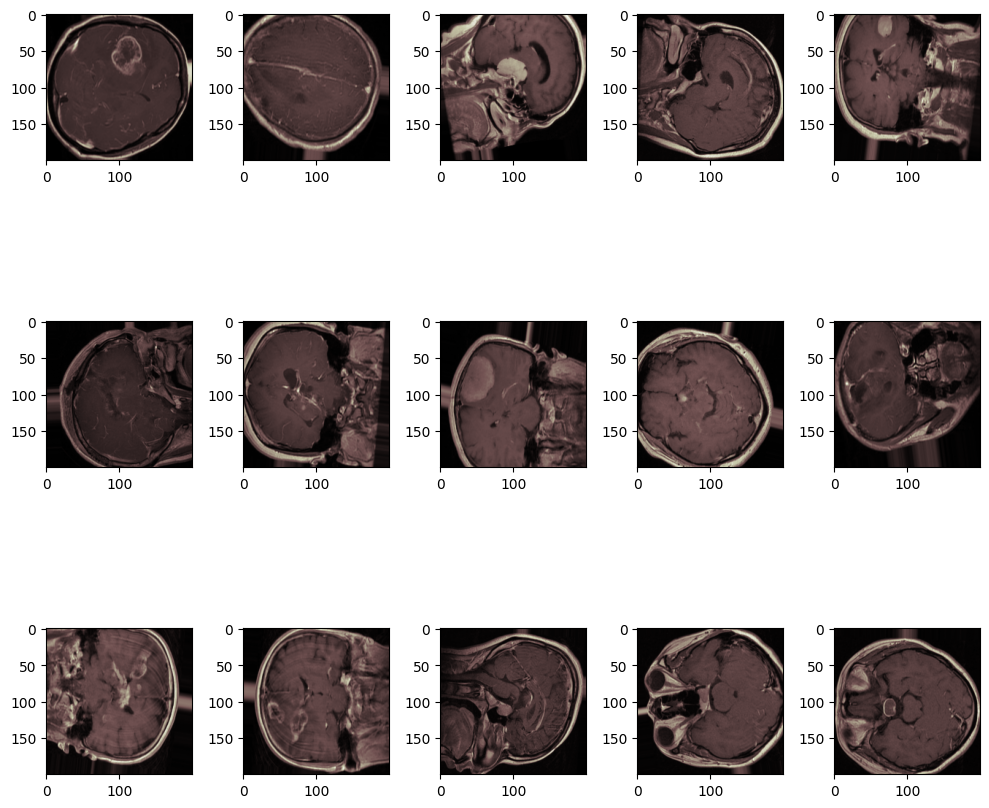

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7572
Epoch 1: saving model to model-Xception.h5
Epoch 1: 36.57 seconds
264/264 [==============================] - 37s 129ms/step - loss: 0.5806 - accuracy: 0.7572 - val_loss: 1.1235 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9041
Epoch 2: saving model to model-Xception.h5
Epoch 2: 32.94 seconds
264/264 [==============================] - 33s 125ms/step - loss: 0.2524 - accuracy: 0.9041 - val_loss: 2.1660 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9548
Epoch 3: saving model to model-Xception.h5
Epoch 3: 32.85 seconds
264/264 [==============================] - 33s 124ms/step - loss: 0.1223 - accuracy: 0.9548 - val_loss: 2.0639 - val_accuracy: 0.4307 - lr: 1.0000e-04
E

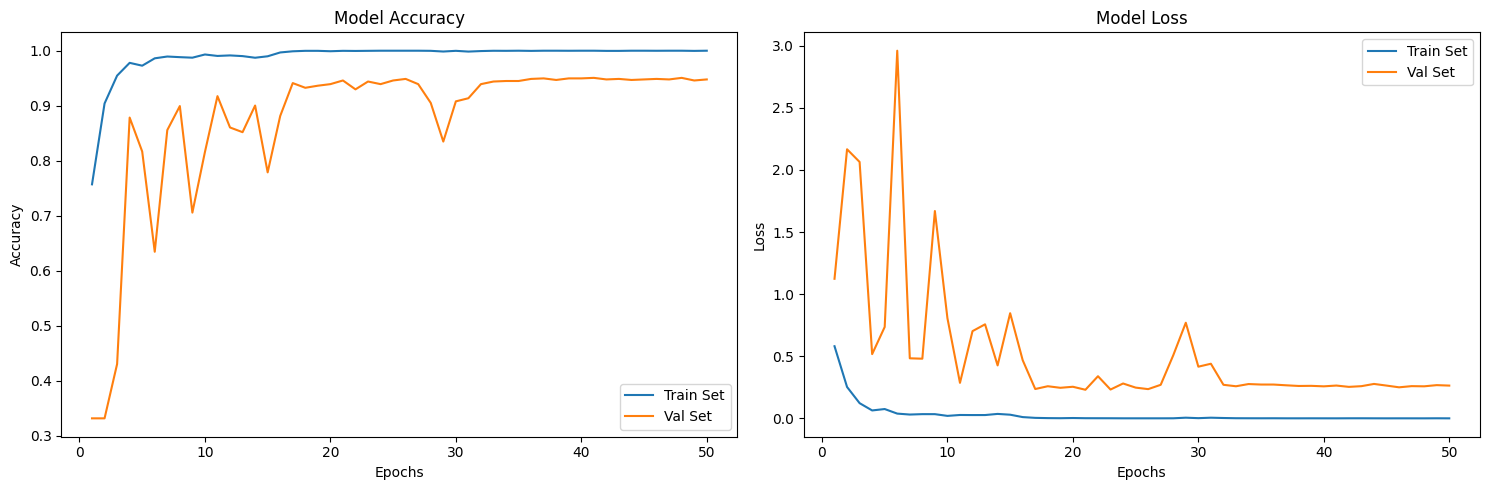

20/20 [==============================] - 0s 18ms/step - loss: 0.2603 - accuracy: 0.9446
Test Accuracy:  94.46
              precision    recall  f1-score   support

      glioma     0.9781    0.9371    0.9571       286
  meningioma     0.8693    0.9366    0.9017       142
   pituitary     0.9572    0.9624    0.9598       186

    accuracy                         0.9446       614
   macro avg     0.9349    0.9453    0.9395       614
weighted avg     0.9466    0.9446    0.9451       614



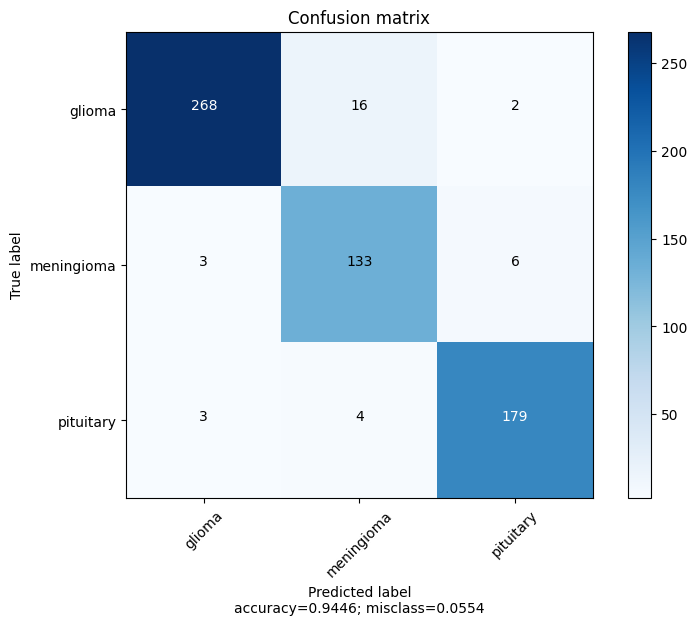

In [14]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.58it/s]


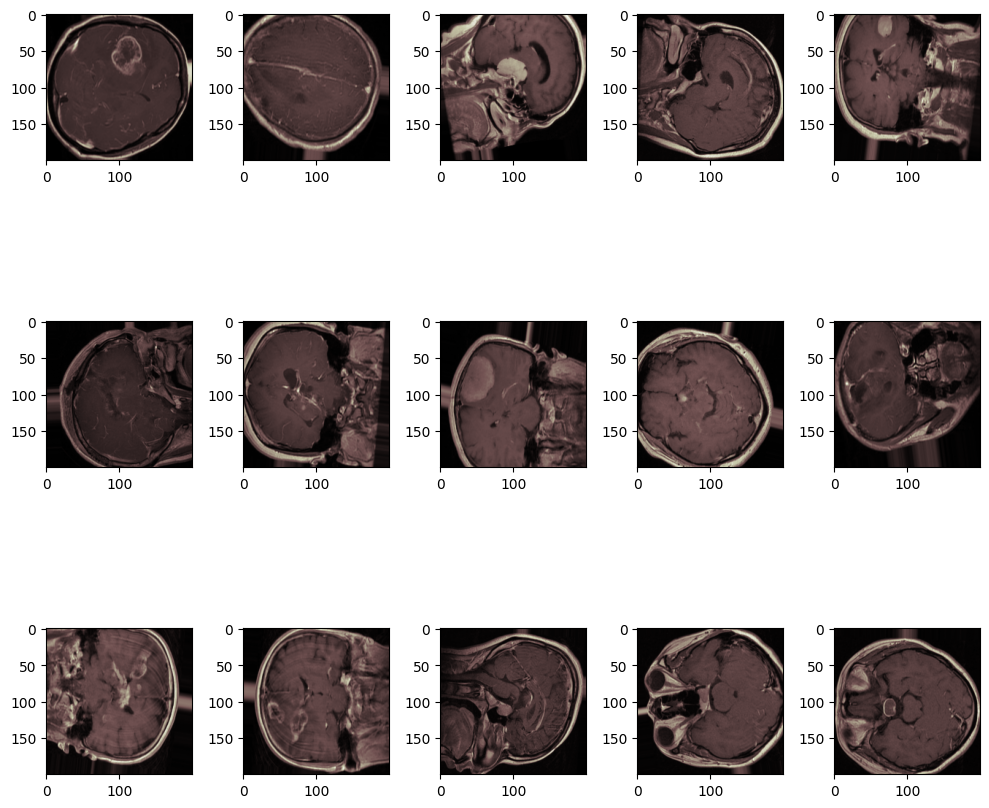

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7541
Epoch 1: saving model to model-Xception.h5
Epoch 1: 37.28 seconds
264/264 [==============================] - 37s 131ms/step - loss: 0.5820 - accuracy: 0.7541 - val_loss: 1.1267 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8962
Epoch 2: saving model to model-Xception.h5
Epoch 2: 33.89 seconds
264/264 [==============================] - 34s 128ms/step - loss: 0.2726 - accuracy: 0.8962 - val_loss: 2.0931 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9570
Epoch 3: saving model to model-Xception.h5
Epoch 3: 33.97 seconds
264/264 [==============================] - 34s 129ms/step - loss: 0.1157 - accuracy: 0.9570 - val_loss: 0.9976 - val_accuracy: 0.6480 - lr: 1.0000e-04
E

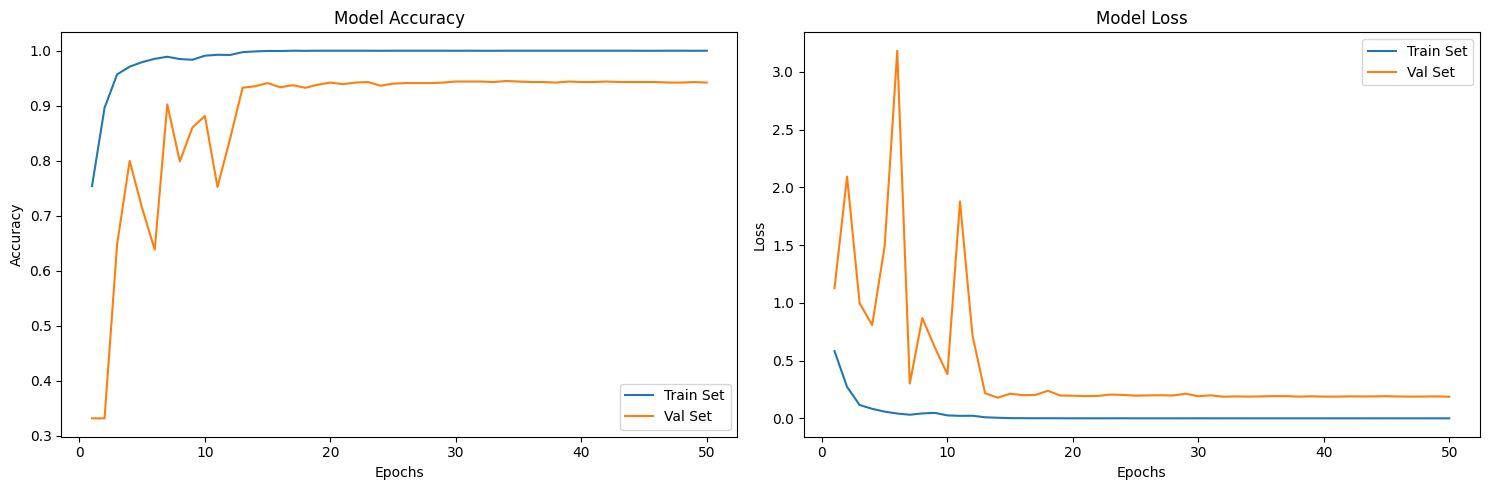

20/20 [==============================] - 0s 18ms/step - loss: 0.2980 - accuracy: 0.9349
Test Accuracy:  93.49
              precision    recall  f1-score   support

      glioma     0.9747    0.9441    0.9591       286
  meningioma     0.8750    0.8873    0.8811       142
   pituitary     0.9223    0.9570    0.9393       186

    accuracy                         0.9349       614
   macro avg     0.9240    0.9295    0.9265       614
weighted avg     0.9358    0.9349    0.9351       614



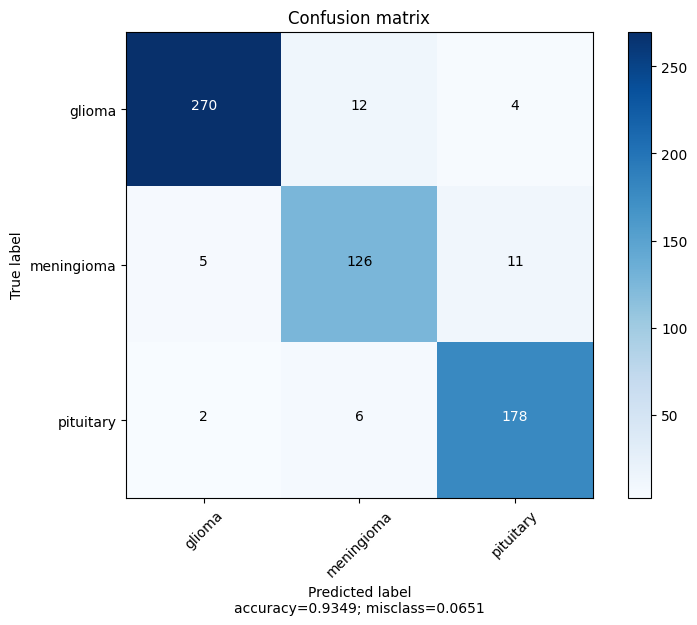

In [16]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)